# Nuages de mots

## Imports et stopwords

In [112]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [122]:
# Téléchargement des ressources NLTK si nécessaire
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [123]:
# stopwords français
sw = set(stopwords.words('french'))

In [124]:
sw |= {
    # Bruit journalistique
    "bruxelles", "brux", "soir", "matin", "jour", "hier", "demain", "samedi", "dimanche", "lundi",
    "mardi", "mercredi", "jeudi", "vendredi", "rossel", "belga", "afp", "hmu", "xix", "xii", "xxe",
    "xxx", "prix", "vente", "achat", "maison", "tél", "tel", "adresse", "programme", "heures",
    "van", "etc", "cette", "tout", "deux", "comme", "sans", "bien", "tous", "grand", "fait",
    "après", "dont", "être", "très", "non", "aussi", "ans", "sous", "france", "encore", "monde",
    "faire", "cours", "trois", "ena", "autres", "entre", "avant", "cela", "alors", "même",
    "depuis", "peu", "fois", "jours", "ainsi", "dire", "autre", "année", "peut", "part",
    "libre", "toute", "moins", "avenue", "chez", "bon", "œuvre", "français", "vers", "petit",
    "quelques", "jusqu", "nouveau", "avoir", "service", "bonne", "lieu", "deuxième", "toutes",
    "jeunes", "francs", "cet", "dit", "admis", "tour",

    # Bruit culturel/événementiel (non pertinent pour les sorcières)
    "musique", "paris", "orchestre", "theatre", "théâtre", "cinéma", "film", "concert", "halloween",
    "costume", "fête", "carnaval", "bd", "dessins", "animés", "série", "feuilleton", "fiction",
    "personnage", "spectacle", "exposition", "galerie", "musée", "opéra", "ballet", "danse",

    # Bruit géographique/urbain
    "ville", "place", "rue", "quartier", "avenue", "boulevard", "carrefour", "gare", "métro",
    "transport", "voiture", "bus", "train", "station", "parking", "bâtiment", "immeuble",

    # Bruit économique/politique
    "pays", "gouvernement", "ministre", "élection", "parti", "loi", "décision", "réunion",
    "conférence", "sommet", "accord", "négociation", "budget", "finance", "banque", "entreprise",

    # Mots trop génériques
    "temps", "vie", "homme", "femme", "enfant", "jeune", "personne", "groupe", "cas", "chose",
    "problème", "question", "moment", "manière", "façon", "type", "sort", "genre", "espèce",

    # Artefacts OCR
    "ena", "hmu", "xii", "xix", "xxe", "xxx", "ooo", "oo", "xxx", "ii", "iii", "iv", "vi", "vii",
    "viii", "ix", "x", "xi", "xiii", "xiv", "xv", "xvi", "xvii", "xviii", "xix", "xx", "xxi",

    # Prénoms fréquents (bruit)
    "jean", "pierre", "marie", "jacques", "michel", "luc", "paul", "henri", "louis", "philippe",
    "andre", "bernard", "robert", "claude", "daniel", "patrick", "thierry", "olivier", "nicolas",
    "christian", "didier", "françois", "serge", "alain", "marc", "yves", "gerard", "rene"
}

# --- MOTS-CIBLES À CONSERVER (MÊME S'ILS SONT DANS LES STOPWORDS) ---
mots_a_conserver = {
    # Sorcellerie
    "sorcière", "sorcières", "sorcellerie", "sorcier", "sorciers", "magie", "envoûtement",
    "sortilège", "maléfice", "pouvoir", "occultes", "occulte", "sabbat", "grimoire", "rituel",
    "magique", "envoûteuse", "envoûteur", "démon", "diable", "satan", "lucifer", "exorcisme",

    # Féminisme
    "féminin", "féminité", "féminisme", "féministes", "mlf", "sororité", "émancipation",
    "libération", "autonomie", "pouvoir", "réappropriation", "symbole", "matriarcat",

    # Justice/persécution
    "procès", "tribunal", "accusation", "torture", "bûcher", "exécution", "châtiment",
    "inquisition", "condamnation", "victime", "aveu", "chasse", "persécution",

    # Folklore
    "légende", "mythe", "conte", "tradition", "potion", "incantation", "macrale", "tchestia",
    "chaman", "druide", "alchimie", "astrologie", "vaudou",

    # Stigmatisation
    "marginale", "rejet", "exclusion", "tabou", "interdit", "hystérie", "folie", "démoniaque",
    "possédée", "maudite", "hérétique", "déviant", "bizarre"
}

### Nettoyage du texte

In [139]:
# Nettoyage du texte
def nettoyer_texte(text):
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Filtrer mots (alphabétiques, >2 caractères, pas dans stopwords)
def filter_words(words):
    return [w for w in words if w.isalpha() and w not in sw and len(w) > 2]

# Extraire l'année depuis le nom de fichier
def extract_year(filename):
    parts = filename.split("_")
    for part in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None


In [140]:
data_path = "../../data/txt_tp4"
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
print(f"Nombre de fichiers thématiques = {len(files)}")


Nombre de fichiers thématiques = 999


### Créer un texte global pour générer le nuage

In [142]:
corpus = []             # Corpus global
corpus_decennies = {}   # Corpus par décennie

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    
    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    
    words = filter_words(text.split())
    
    corpus.extend(words)
    
    corpus_decennies.setdefault(dec, [])
    corpus_decennies[dec].append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus))


Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 2315216


### Nouage de mots globale

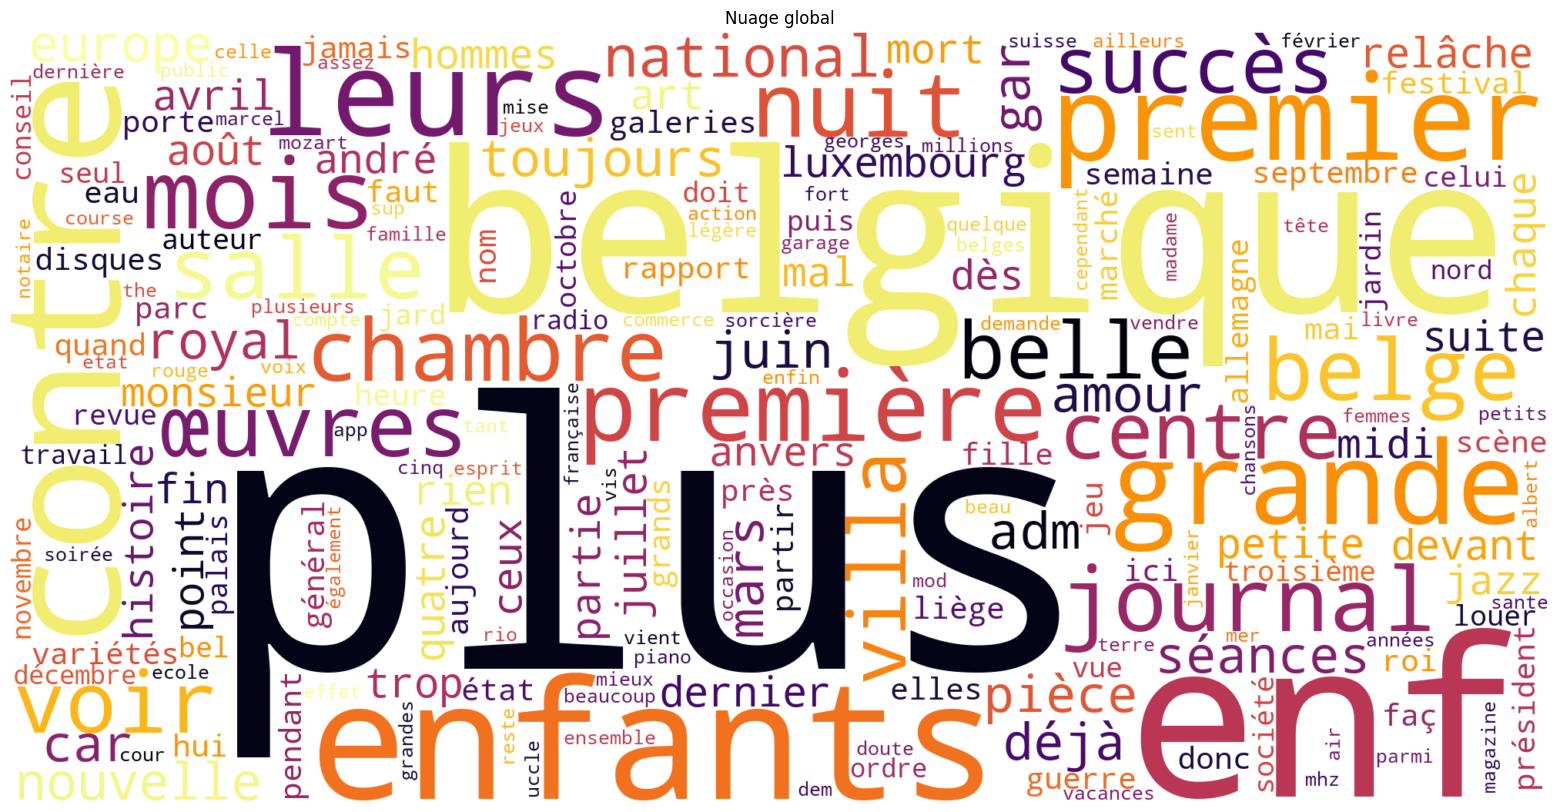

In [143]:
frequencies = Counter(corpus)

cloud = WordCloud(
    width=2000, height=1000,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(frequencies)

plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage global")
plt.show()


### Nouages de mots par decennie

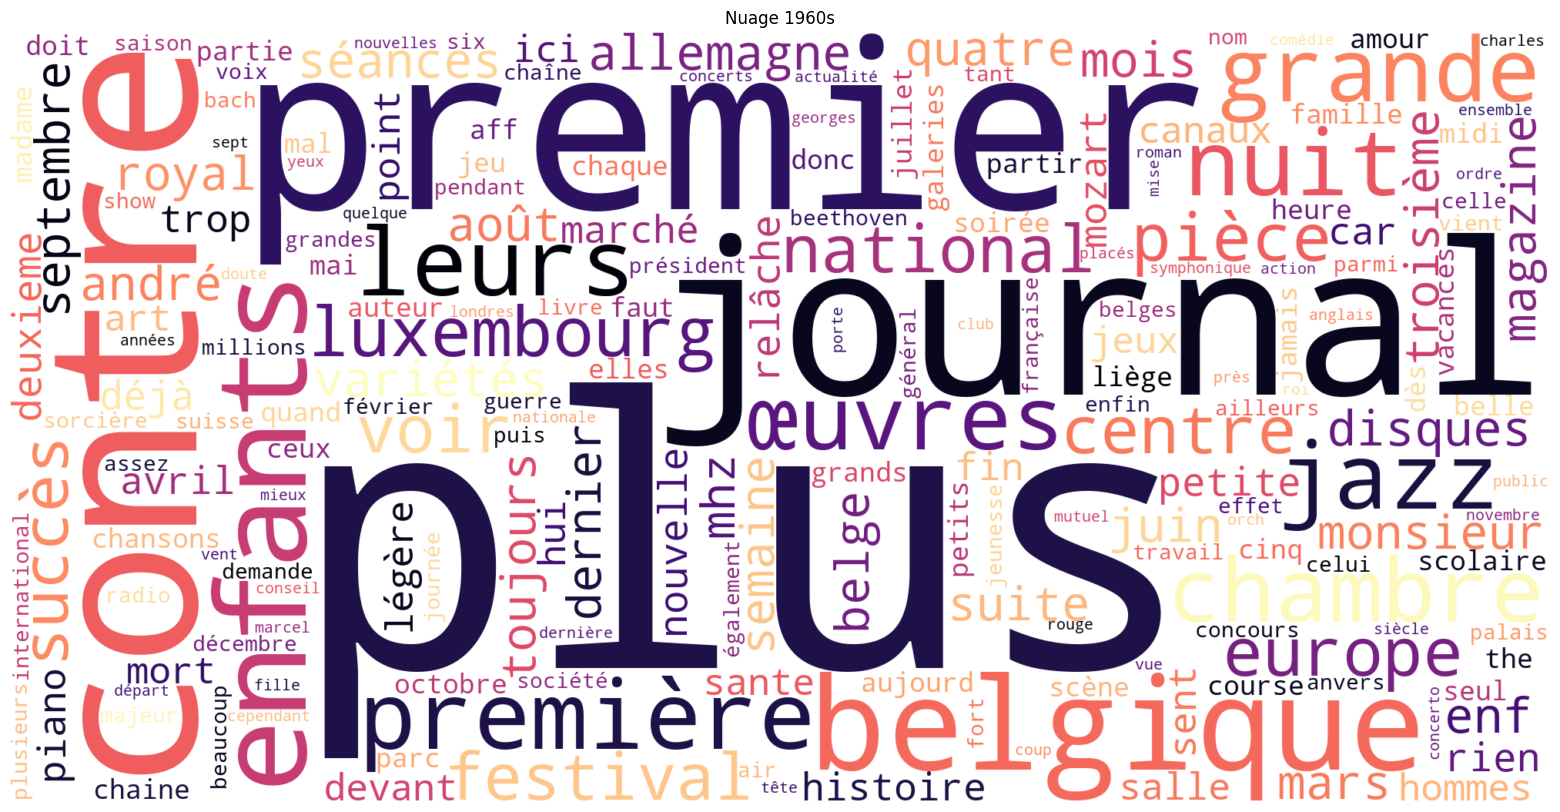

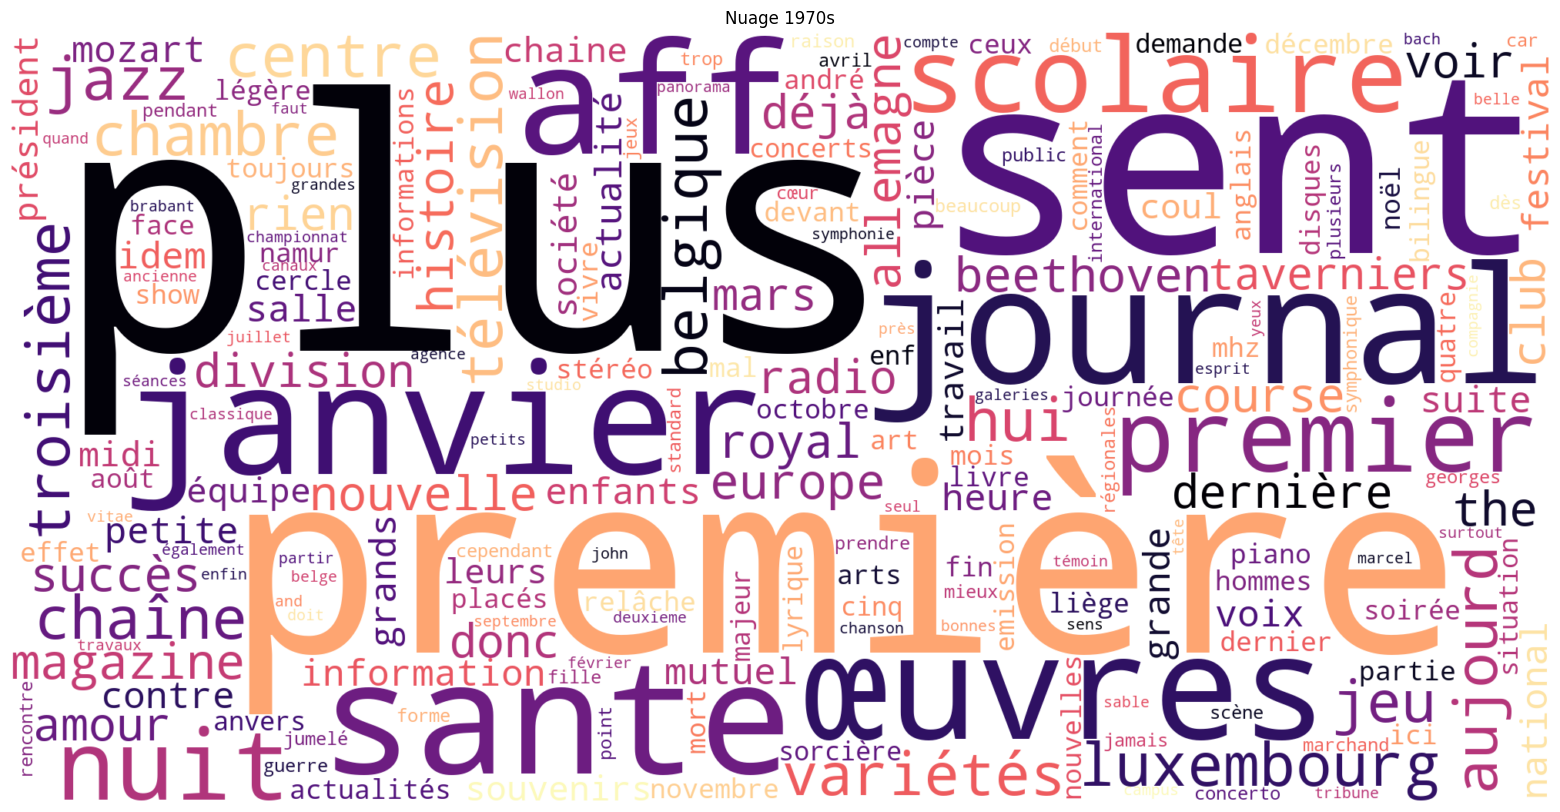

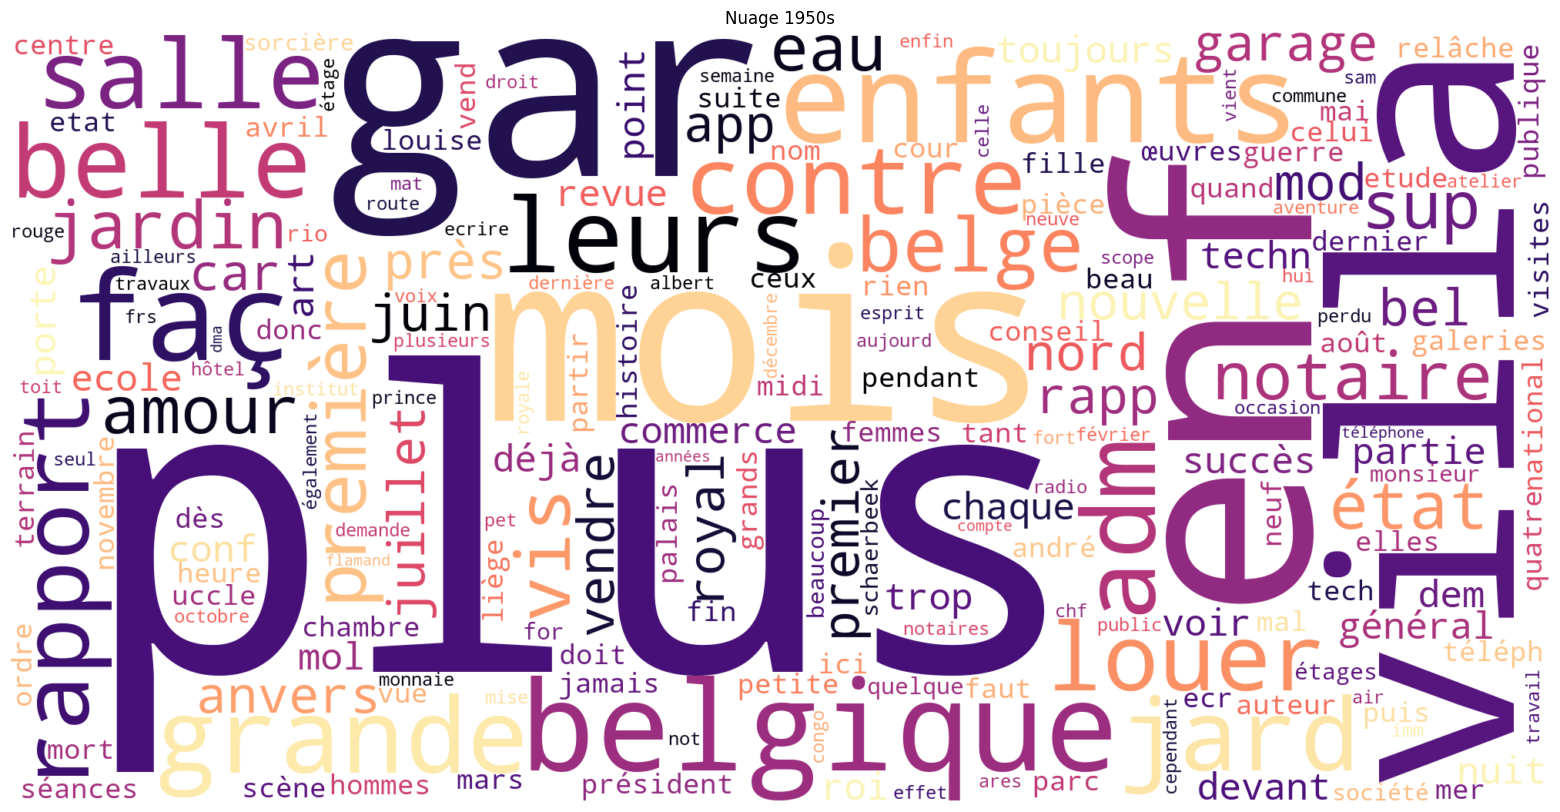

In [144]:
for dec, textes in corpus_decennies.items():
    words_dec = filter_words(" ".join(textes).split())
    freq_dec = Counter(words_dec)
    
    cloud_dec = WordCloud(
        width=2000, height=1000,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(freq_dec)
    
    plt.figure(figsize=(20,10))
    plt.imshow(cloud_dec, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage {dec}s")
    plt.show()


### TF-IDF sur corpus global

In [145]:
documents = []
for f in files:
    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    words = filter_words(text.split())
    documents.append(" ".join(words))

vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(documents)

# Moyenne des scores TF-IDF par mot
import numpy as np
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().mean(axis=0)))
sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 30 mots TF-IDF :", sorted_words[:30])


Top 30 mots TF-IDF : [('plus', np.float64(0.36177581815861626)), ('enf', np.float64(0.13380196113450696)), ('journal', np.float64(0.10082946379021836)), ('leurs', np.float64(0.09355012772701683)), ('belgique', np.float64(0.09113403490395237)), ('premier', np.float64(0.08737170622841668)), ('enfants', np.float64(0.08728732106579991)), ('œuvres', np.float64(0.084238821807909)), ('adm', np.float64(0.08260387855448072)), ('contre', np.float64(0.08254697603603343)), ('première', np.float64(0.08153733911137441)), ('gar', np.float64(0.07893793156862088)), ('luxembourg', np.float64(0.07802523052232084)), ('chambre', np.float64(0.07731003257977864)), ('séances', np.float64(0.07678879448014764)), ('mois', np.float64(0.07543840931927932)), ('nuit', np.float64(0.07520438539254473)), ('grande', np.float64(0.07505228520434579)), ('relâche', np.float64(0.07397358871279955)), ('belge', np.float64(0.06997665964532597)), ('villa', np.float64(0.06849118944898999)), ('salle', np.float64(0.0679583402865416

### Nuage TF-IDF 

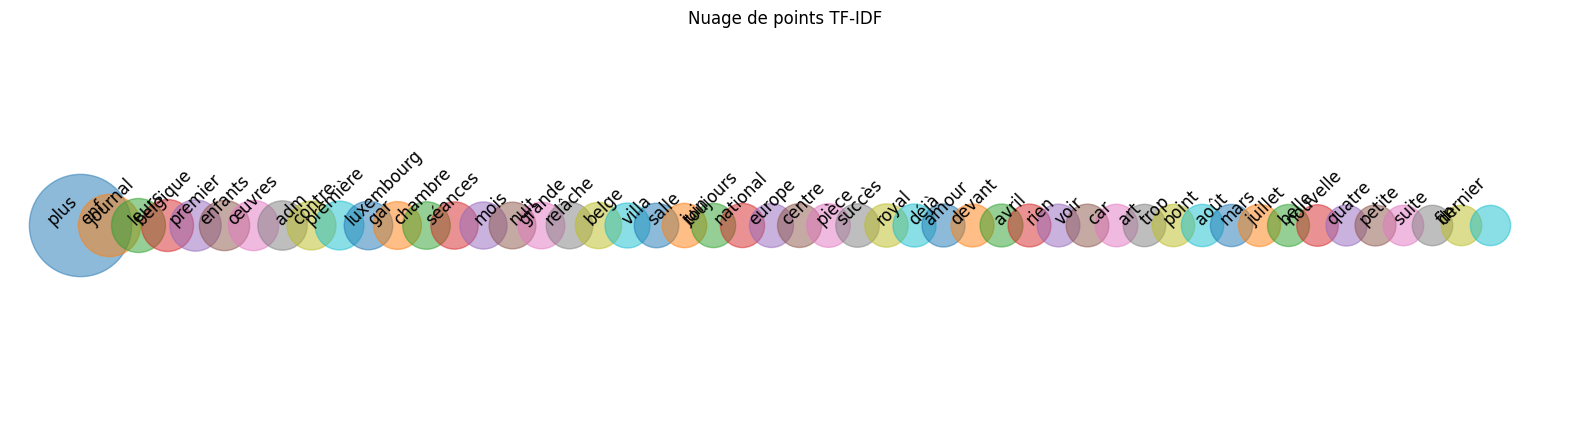

In [146]:
plt.figure(figsize=(20,5))
for i, (word, score) in enumerate(sorted_words):
    plt.scatter(i, 0, s=score*15000, alpha=0.5)
    plt.text(i, 0, word, fontsize=12, rotation=45, ha='right')
plt.axis('off')
plt.title("Nuage de points TF-IDF")
plt.show()
